Loaded 91 individual squadrat polygons
Loaded 130 individual squadratinho polygons
Saved plot to output_all_polygons.png


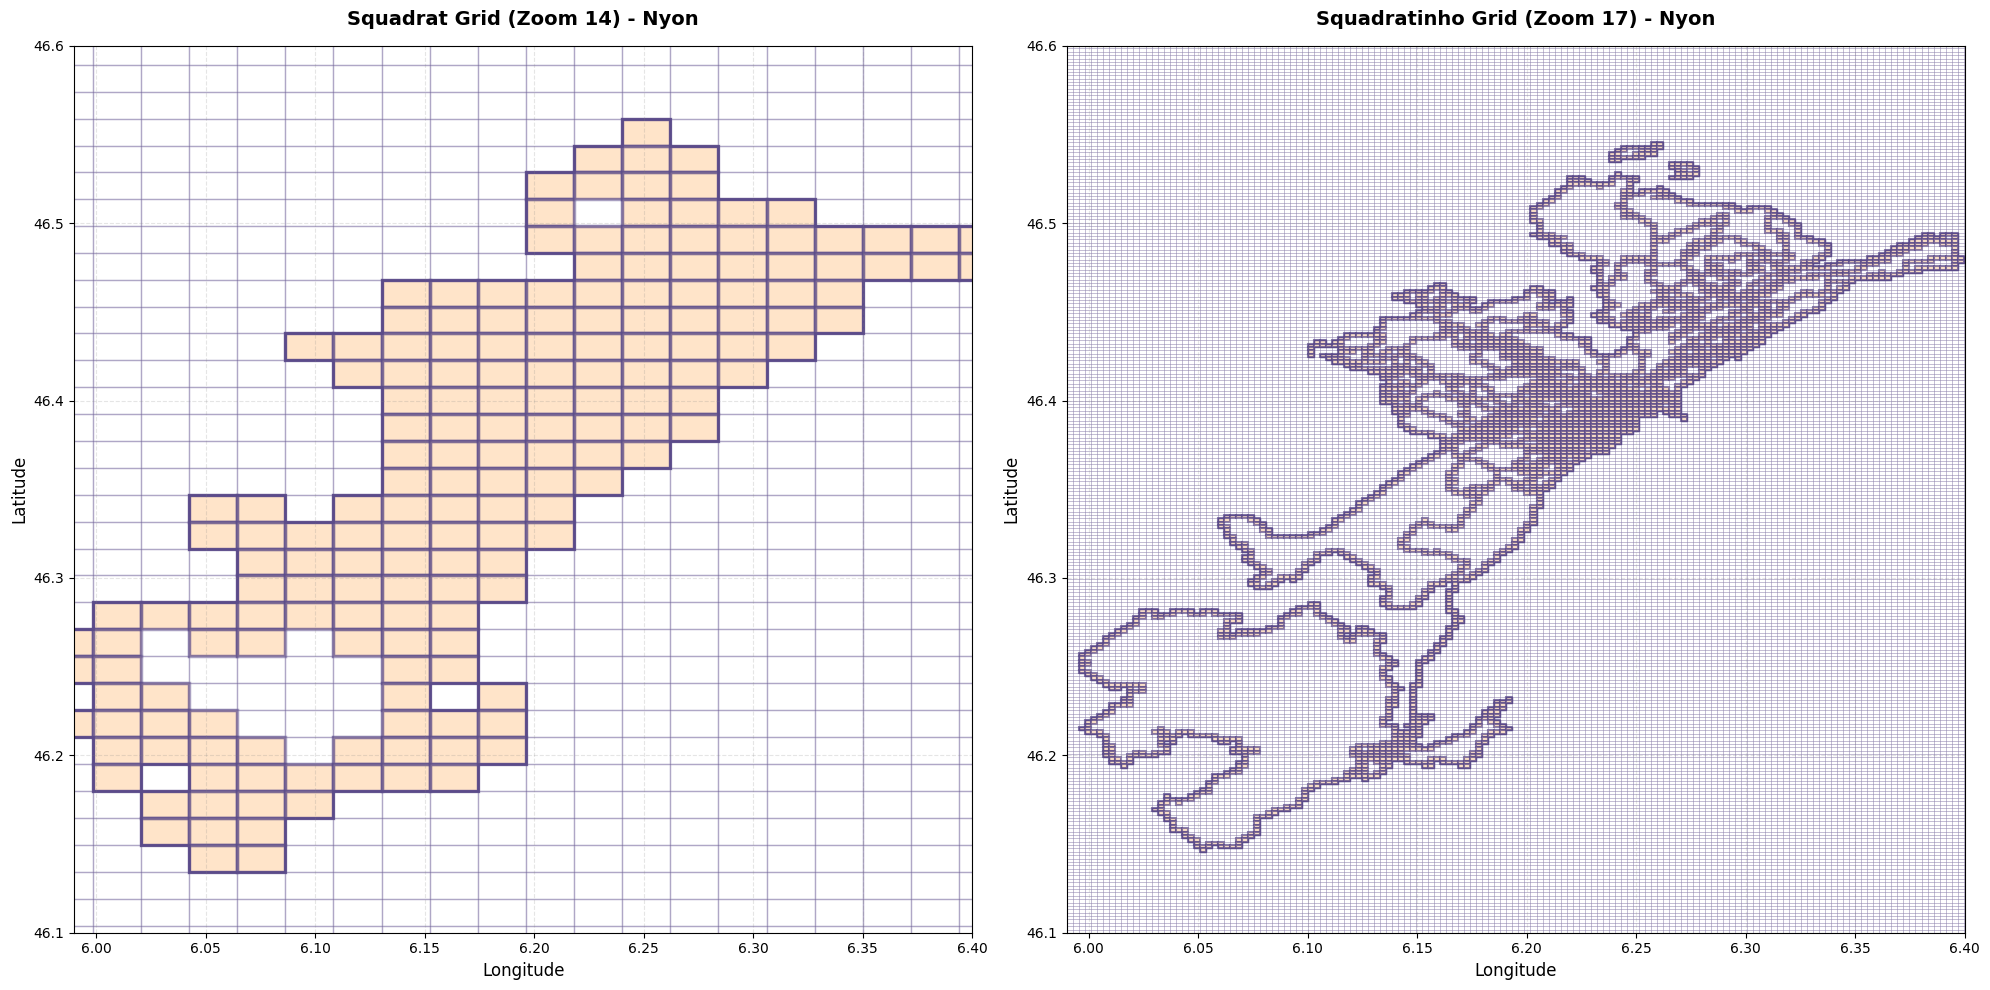

Saved grid mask to output/squadrat_grid_mask_Nyon.csv

Squadrat Grid (Zoom 14) - Using ALL Polygons:
  Total tiles: 680
  Tiles inside polygons (1): 178
  Tiles outside polygons (0): 502
  Coverage: 26.2%
Saved grid mask to output/squadratinho_grid_mask_Nyon.csv

Squadratinho Grid (Zoom 17) - Using ALL Polygons:
  Total tiles: 39864
  Tiles inside polygons (1): 3396
  Tiles outside polygons (0): 36468
  Coverage: 8.5%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd
from matplotlib.patches import Polygon
from matplotlib.path import Path
import csv
from shapely.geometry import Point, MultiPolygon

def latlon_to_tile(lat, lon, zoom):
    """Convert lat/lon to tile coordinates at given zoom level"""
    lat_rad = np.radians(lat)
    n = 2.0 ** zoom
    xtile = int((lon + 180.0) / 360.0 * n)
    ytile = int((1.0 - np.arcsinh(np.tan(lat_rad)) / np.pi) / 2.0 * n)
    return xtile, ytile

def tile_to_latlon(x, y, zoom):
    """Convert tile coordinates to lat/lon (northwest corner)"""
    n = 2.0 ** zoom
    lon = x / n * 360.0 - 180.0
    lat_rad = np.arctan(np.sinh(np.pi * (1 - 2 * y / n)))
    lat = np.degrees(lat_rad)
    return lat, lon

def get_tile_bounds(x, y, zoom):
    """Get the lat/lon bounds of a tile"""
    lat_nw, lon_nw = tile_to_latlon(x, y, zoom)
    lat_se, lon_se = tile_to_latlon(x + 1, y + 1, zoom)
    return lon_nw, lon_se, lat_se, lat_nw  # west, east, south, north

def load_all_polygons_geopandas(kml_file):
    """
    Load ALL individual polygons from KML using geopandas
    Returns separate lists for squadrats and squadratinhos
    """
    # Load the KML file
    gdf = gpd.read_file(kml_file, driver="KML")
    
    squadrat_geoms = []
    squadratinho_geoms = []
    
    # Separate by name
    for idx, row in gdf.iterrows():
        name = str(row['Name']).lower() if 'Name' in row else ''
        geom = row.geometry
        
        if geom is None:
            continue
        
        # Handle MultiPolygon - extract all individual polygons
        if geom.geom_type == 'MultiPolygon':
            for poly in geom.geoms:
                if 'squadratinho' in name:
                    squadratinho_geoms.append(poly)
                else:
                    squadrat_geoms.append(poly)
        # Handle single Polygon
        elif geom.geom_type == 'Polygon':
            if 'squadratinho' in name:
                squadratinho_geoms.append(geom)
            else:
                squadrat_geoms.append(geom)
    
    print(f"Loaded {len(squadrat_geoms)} individual squadrat polygons")
    print(f"Loaded {len(squadratinho_geoms)} individual squadratinho polygons")
    
    return squadrat_geoms, squadratinho_geoms

def point_in_shapely_polygons(lon, lat, shapely_geoms):
    """Check if a point is inside ANY of the shapely polygons"""
    point = Point(lon, lat)
    for geom in shapely_geoms:
        if geom.contains(point):
            return True
    return False

def create_grid_mask(tiles, shapely_geoms):
    """Create binary mask: 1 if tile center is inside any polygon, 0 otherwise"""
    mask = []
    for tile in tiles:
        x, y, west, east, south, north = tile
        center_lon = (west + east) / 2
        center_lat = (south + north) / 2
        inside = 1 if point_in_shapely_polygons(center_lon, center_lat, shapely_geoms) else 0
        mask.append((x, y, inside))
    return mask

def save_grid_mask_csv(mask, zoom, filename):
    """Save grid mask to CSV file"""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['tile_x', 'tile_y', 'zoom', 'inside_polygon'])
        for x, y, inside in mask:
            writer.writerow([x, y, zoom, inside])
    print(f"Saved grid mask to {filename}")

def get_tiles_in_bounds(lon_min, lon_max, lat_min, lat_max, zoom):
    """Get all tiles that intersect with the given bounds"""
    # Get tile coordinates for corners
    x_min, y_max = latlon_to_tile(lat_min, lon_min, zoom)  # SW corner
    x_max, y_min = latlon_to_tile(lat_max, lon_max, zoom)  # NE corner
    
    tiles = []
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            west, east, south, north = get_tile_bounds(x, y, zoom)
            tiles.append((x, y, west, east, south, north))
    
    return tiles

def create_mapbox_grids_with_all_polygons(kml_file, region = 'Nyon',
                                          lon_min=5.99, lon_max=6.4, 
                                          lat_min=46.1, lat_max=46.6,
                                          zoom_squadrat=14, zoom_squadratinho=17, 
                                          figsize=(20, 10)):
    """
    Create squadrat and squadratinho grids using ALL individual polygons from KML
    This ensures accurate masking that respects holes and gaps in the multipolygon
    
    Parameters:
    - kml_file: Path to KML file with multipolygons
    - lon_min, lon_max, lat_min, lat_max: Bounds of the region to display
    - zoom_squadrat: Zoom level for squadrat grid (default 14)
    - zoom_squadratinho: Zoom level for squadratinho grid (default 17)
    - figsize: Figure size for matplotlib
    """
    
    # Load ALL individual polygons from KML using geopandas
    squadrat_geoms = []
    squadratinho_geoms = []
    
    if kml_file:
        try:
            squadrat_geoms, squadratinho_geoms = load_all_polygons_geopandas(kml_file)
        except Exception as e:
            print(f"Error loading KML file: {e}")
            import traceback
            traceback.print_exc()
            return None, None
    
    # Get all tiles in the specified bounds
    squadrat_tiles = get_tiles_in_bounds(lon_min, lon_max, lat_min, lat_max, zoom_squadrat)
    squadratinho_tiles = get_tiles_in_bounds(lon_min, lon_max, lat_min, lat_max, zoom_squadratinho)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # --- SQUADRAT GRID (Zoom 14) ---
    ax1.set_title(f'Squadrat Grid (Zoom {zoom_squadrat}) - {region}', 
                  fontsize=14, fontweight='bold', pad=15)
    
    for tile in squadrat_tiles:
        x, y, west, east, south, north = tile
        center_lon_tile = (west + east) / 2
        center_lat_tile = (south + north) / 2
        
        # Check if tile center is inside ANY squadrat polygon
        inside = point_in_shapely_polygons(center_lon_tile, center_lat_tile, squadrat_geoms) if squadrat_geoms else False
        
        # Color based on whether inside polygon
        if inside:
            facecolor = '#FFD9B3'  # Light orange (peach)
            edgecolor = '#5B4B8A'  # Purple border
            alpha = 0.7
            linewidth = 2.5
        else:
            facecolor = 'white'
            edgecolor = '#5B4B8A'  # Purple border
            alpha = 0.3
            linewidth = 1.0
        
        # Create rectangle
        rect = patches.Rectangle((west, south), east - west, north - south,
                                 linewidth=linewidth, edgecolor=edgecolor, 
                                 facecolor=facecolor, alpha=alpha)
        ax1.add_patch(rect)
    
    # Overlay ALL individual polygon borders
    if squadrat_geoms:
        for geom in squadrat_geoms:
            if geom.geom_type == 'Polygon':
                # Get exterior coordinates
                coords = list(geom.exterior.coords)
                xy = [(lon, lat) for lon, lat in coords]
                poly = Polygon(xy, linewidth=2, edgecolor='#5B4B8A', 
                              facecolor='none', alpha=1.0)
                ax1.add_patch(poly)
    
    ax1.set_xlim([lon_min, lon_max])
    ax1.set_ylim([lat_min, lat_max])
    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.grid(True, alpha=0.2, linestyle='--', color='gray')
    
    # --- SQUADRATINHO GRID (Zoom 17) ---
    ax2.set_title(f'Squadratinho Grid (Zoom {zoom_squadratinho}) - {region}', 
                  fontsize=14, fontweight='bold', pad=15)
    
    for tile in squadratinho_tiles:
        x, y, west, east, south, north = tile
        center_lon_tile = (west + east) / 2
        center_lat_tile = (south + north) / 2
        
        # Check if tile center is inside ANY squadratinho polygon
        inside = point_in_shapely_polygons(center_lon_tile, center_lat_tile, squadratinho_geoms) if squadratinho_geoms else False
        
        # Color based on whether inside polygon
        if inside:
            facecolor = '#FFD9B3'  # Light orange (peach)
            edgecolor = '#5B4B8A'  # Purple border
            alpha = 0.7
            linewidth = 1.5
        else:
            facecolor = 'white'
            edgecolor = '#5B4B8A'  # Purple border
            alpha = 0.3
            linewidth = 0.5
        
        # Create rectangle
        rect = patches.Rectangle((west, south), east - west, north - south,
                                 linewidth=linewidth, edgecolor=edgecolor, 
                                 facecolor=facecolor, alpha=alpha)
        ax2.add_patch(rect)
    
    # Overlay ALL individual polygon borders
    if squadratinho_geoms:
        for geom in squadratinho_geoms:
            if geom.geom_type == 'Polygon':
                # Get exterior coordinates
                coords = list(geom.exterior.coords)
                xy = [(lon, lat) for lon, lat in coords]
                poly = Polygon(xy, linewidth=1, edgecolor='#5B4B8A', 
                              facecolor='none', alpha=1.0)
                ax2.add_patch(poly)
    
    ax2.set_xlim([lon_min, lon_max])
    ax2.set_ylim([lat_min, lat_max])
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.set_ylabel('Latitude', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='--', color='gray')
    
    plt.tight_layout()
    plt.savefig(f'figure/{region}_grids.png', dpi=150, bbox_inches='tight')
    print("Saved plot to output_all_polygons.png")
    plt.show()
    
    # Create and save grid masks
    if squadrat_geoms or squadratinho_geoms:
        if squadrat_geoms:
            squadrat_mask = create_grid_mask(squadrat_tiles, squadrat_geoms)
            save_grid_mask_csv(squadrat_mask, zoom_squadrat, f'output/squadrat_grid_mask_{region}.csv')
            
            # Count statistics
            squadrat_inside = sum(1 for _, _, inside in squadrat_mask if inside == 1)
            squadrat_outside = sum(1 for _, _, inside in squadrat_mask if inside == 0)
            
            print(f"\nSquadrat Grid (Zoom {zoom_squadrat}) - Using ALL Polygons:")
            print(f"  Total tiles: {len(squadrat_tiles)}")
            print(f"  Tiles inside polygons (1): {squadrat_inside}")
            print(f"  Tiles outside polygons (0): {squadrat_outside}")
            print(f"  Coverage: {squadrat_inside/len(squadrat_tiles)*100:.1f}%")
        
        if squadratinho_geoms:
            squadratinho_mask = create_grid_mask(squadratinho_tiles, squadratinho_geoms)
            save_grid_mask_csv(squadratinho_mask, zoom_squadratinho, f'output/squadratinho_grid_mask_{region}.csv')
            
            # Count statistics
            squadratinho_inside = sum(1 for _, _, inside in squadratinho_mask if inside == 1)
            squadratinho_outside = sum(1 for _, _, inside in squadratinho_mask if inside == 0)
            
            print(f"\nSquadratinho Grid (Zoom {zoom_squadratinho}) - Using ALL Polygons:")
            print(f"  Total tiles: {len(squadratinho_tiles)}")
            print(f"  Tiles inside polygons (1): {squadratinho_inside}")
            print(f"  Tiles outside polygons (0): {squadratinho_outside}")
            print(f"  Coverage: {squadratinho_inside/len(squadratinho_tiles)*100:.1f}%")
    
    return squadrat_tiles, squadratinho_tiles

# Main execution
if __name__ == "__main__":
    # Specify your KML file path here
    kml_file_path = '/Users/epauthen/Documents/Database/Squadrats/squadrats-2025-11-13.kml'
    
    # Create grids for the specified region using ALL polygons
    squadrat, squadratinho = create_mapbox_grids_with_all_polygons(
        kml_file=kml_file_path,
        region = "Nyon",
        lon_min=5.99,
        lon_max=6.4,
        lat_min=46.1,
        lat_max=46.6,
        zoom_squadrat=14,
        zoom_squadratinho=17
    )

#        region = "Lausanne",
#        lon_min=6.55,
#        lon_max=6.72,
#        lat_min=46.45,
#        lat_max=46.62,

#        region = 'Stockholm',
#        lon_min=17.75,
#        lon_max=18.36,
#        lat_min=59.25,
#        lat_max=59.7,

#        region = "Lyon",
#       lon_min=4.65,
#        lon_max=4.9,
#        lat_min=45.625,
#        lat_max=45.8,

#        region = "Briancon",
#        lon_min=6.34,
#        lon_max=6.8,
#        lat_min=44.76,
#        lat_max=45.1,

#        region = "Nyon",
#        lon_min=5.99,
#        lon_max=6.4,
#        lat_min=46.1,
#        lat_max=46.6,
#Paris
#        lon_min=1.5,
#        lon_max=3.5,
#        lat_min=48.3,
#        lat_max=49.3,
